In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import random
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
from torch.nn import functional as F
import scipy

from matplotlib import style
import pathlib
from sklearn.linear_model import LogisticRegression
plt.style.use('seaborn-v0_8')

In [ ]:
final_df = pd.read_csv("drive/MyDrive/CV2_project/code/med_vlm_cal/output/few_shot_exp/final_df_04-07-2024_15-49-51.csv")

In [ ]:
final_df

,dataset,model,cal_fn,n_val,trial_no,alpha,ece1,ece2,acc
0,renal_cell,plip,platt,250,0,0.0,0.074878,0.083641,0.482835
1,renal_cell,plip,platt,250,1,0.0,0.037200,0.052578,0.481468
2,renal_cell,plip,platt,250,2,0.0,0.049002,0.057554,0.480911
3,renal_cell,plip,platt,250,3,0.0,0.023301,0.028832,0.481519
4,renal_cell,plip,platt,250,4,0.0,0.035331,0.043031,0.481873
...,...,...,...,...,...,...,...,...,...
31303,lc25000_colon,quilt,platt_bin,2000,5,1.0,0.053723,0.072773,0.994124
31304,lc25000_colon,quilt,platt_bin,2000,6,1.0,0.053061,0.071138,0.993624
31305,lc25000_colon,quilt,platt_bin,2000,7,1.0,0.053051,0.071860,0.993624
31306,lc25000_colon,quilt,platt_bin,2000,8,1.0,0.053480,0.072732,0.993499


In [ ]:
cal_fns = [
    "hist",
    "platt",
    "platt_bin"
]

cal_fn_map = {
    "platt": "Platt scale",
    "hist": "Histogram bin",
    "platt_bin": "Platt bin",
}

n_vals = [
    250,
    500,
    1000,
    2000
]

models = [
    "biomed",
    "plip",
    "quilt",
]

model_map = {
    "plip": "PLIP",
    "biomed": "BioMedCLIP",
    "quilt": "QuiltNet",
}

datasets = [
    "databiox",
    "sicap",
    "renal_cell",
    "bach",
    "osteo",
    "nck",
    "skin_tumor",
    "skin",
    "pcam",
    "mhist",
    "lc25000_lung",
    "lc25000_colon",
]

dataset_map = {
    "databiox": "Databiox",
    "sicap": "SICAP",
    "renal_cell": "RenalCell",
    "bach": "BACH",
    "osteo": "Osteo",
    "nck": "NCK-CRC",
    "skin_tumor": "Skin Tumor",
    "skin": "Skin Cancer",
    "pcam": "PCam",
    "lc25000_lung": "LC-Lung",
    "lc25000_colon": "LC-Colon",
    "mhist": "MHIST"
}



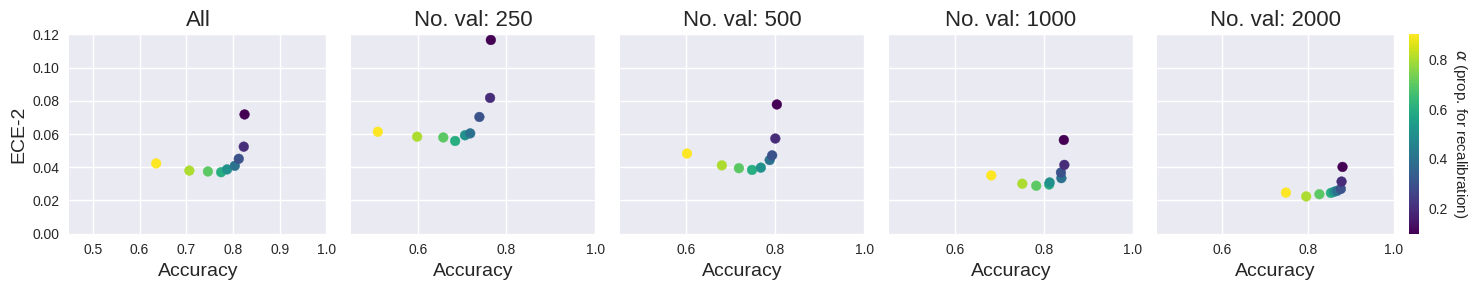

In [ ]:
plt.rcParams["figure.figsize"] = (15,3)
fig, axs = plt.subplots(1,5, width_ratios=[0.20, 0.19, 0.19, 0.19, 0.23])
cm = plt.colormaps.get_cmap('viridis')

alphas = np.array([i/10 for i in range(11)])

grouped = final_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
axs[0].scatter(grouped["acc"].tolist()[1:10], grouped["ece2"].tolist()[1:10], c=1-alphas[1:10], cmap=cm)


for j, n_val in enumerate(n_vals):
  sub_df = final_df[final_df['n_val'] == n_val]

  grouped = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
  # display(grouped)
  # axs[0].scatter(grouped["acc"].tolist()[1:10], grouped["ece1"].tolist()[1:10], c=alphas[1:10], cmap=cm)
  # axs[0].set_xlabel("Accuracy")
  # axs[0].set_ylabel("ECE1")

  sc = axs[j+1].scatter(grouped["acc"].tolist()[1:10], grouped["ece2"].tolist()[1:10], c=1-alphas[1:10], cmap=cm)


for idx, ax in enumerate(axs):
  ax.set_xlim(0.45, 1.0)
  ax.set_ylim(0.0, 0.12)
  if idx == 0:
    ax.set_title("All", fontsize=16)
    ax.set_ylabel("ECE-2", fontsize=14)
  else:
    ax.set_title("No. val: "+str(n_vals[idx-1]), fontsize=16)
    ax.set_yticks(axs[0].get_yticks(), [])
  ax.set_xlabel("Accuracy", fontsize=14)

cb = plt.colorbar(sc)
cb.ax.set_ylabel(r"$\alpha$ (prop. for recalibration)", rotation=270, labelpad=15)

fig.tight_layout()
plt_save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/plots/"
plt.savefig(plt_save_path+"few_shot_pareto.png", dpi=600, bbox_inches='tight')
plt.show()

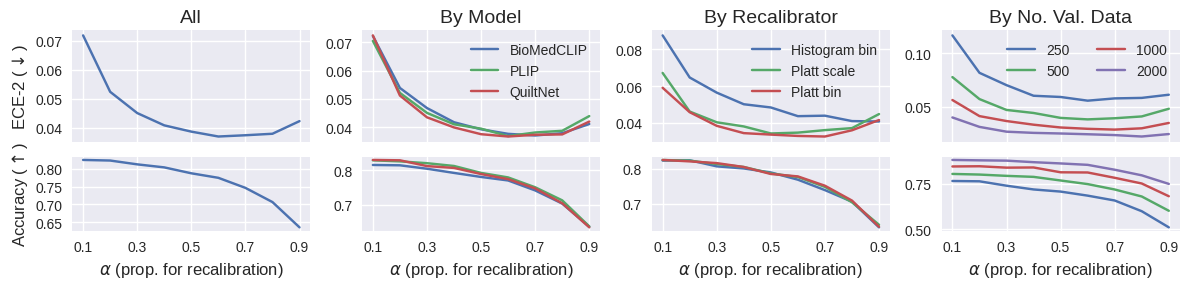

In [ ]:
plt.rcParams["figure.figsize"] = (12,3)

alphas = np.array([i/10 for i in range(1,10)])
fig, axs = plt.subplots(2, 4, height_ratios=[0.6, 0.4])

plot_df = final_df[(final_df["alpha"] != 1.0) & (final_df["alpha"] != 0.0)]

grouped_cal = plot_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
axs[0,0].plot(1-alphas, grouped_cal["ece2"])
axs[1,0].plot(1-alphas, grouped_cal["acc"])

for model in models:
    sub_df = plot_df[plot_df["model"] == model]
    grouped_cal = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
    axs[0,1].plot(1-alphas, grouped_cal["ece2"][:10], label=model_map[model])
    axs[1,1].plot(1-alphas, grouped_cal["acc"][:10], label=model_map[model])

for cal_fn in cal_fns:
    sub_df = plot_df[plot_df["cal_fn"] == cal_fn]
    grouped_cal = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
    axs[0,2].plot(1-alphas, grouped_cal["ece2"][:10], label=cal_fn_map[cal_fn])
    axs[1,2].plot(1-alphas, grouped_cal["acc"][:10], label=cal_fn_map[cal_fn])

for n_val in n_vals:
    sub_df = plot_df[plot_df["n_val"] == n_val]
    grouped_cal = sub_df[["alpha", "ece1", "ece2", "acc"]].groupby(["alpha"]).mean()
    axs[0,3].plot(1-alphas, grouped_cal["ece2"][:10], label=n_val)
    axs[1,3].plot(1-alphas, grouped_cal["acc"][:10], label=n_val)

for i in range(2):
    for j in range(4):
        if j != 0 and i != 1:
            if j == 3:
                axs[i,j].legend(fontsize=10, ncol=2)
            else:
                axs[i,j].legend(fontsize=10)

        if i == 0 and j == 0:
            # axs[i,j].set_xlabel("Alpha")
            axs[i,j].set_ylabel(r"ECE-2 ($\downarrow$)", fontsize=12)
        elif i == 1 and j == 0:
            axs[i,j].set_xlabel(r"$\alpha$ (prop. for recalibration)", fontsize=12)
            axs[i,j].set_ylabel(r"Accuracy ($\uparrow$)", fontsize=12)
        elif i == 1:
            axs[i,j].set_xlabel(r"$\alpha$ (prop. for recalibration)", fontsize=12)

        if i == 0:
            axs[i,j].set_xticks(np.arange(1,10, 2)/10, [])
        else:
            axs[i,j].set_xticks(np.arange(1,10, 2)/10)


axs[0,0].set_title("All", fontsize=14)
axs[0,1].set_title("By Model", fontsize=14)
axs[0,2].set_title("By Recalibrator", fontsize=14)
axs[0,3].set_title("By No. Val. Data", fontsize=14)

axs[1,0].set_yticks([0.65, 0.7, 0.75, 0.8])

fig.tight_layout()

# plt.savefig("./plots/few_shot_by_alpha.png", dpi=600, bbox_inches='tight')
plt_save_path = "drive/MyDrive/CV2_project/code/med_vlm_cal/plots/"
plt.savefig(plt_save_path+"few_shot_adaptation.png", dpi=600, bbox_inches='tight')

plt.show()

# Observations

 - roughly 50/50 split brings good tradeoff. in a small data situation, try to use at least 100, but for simple recalibrators marginal return goes down around 500 examples.
 - Base model doesn't matter much if you're adapting
 - Scaling recalibrators better than binning-only
 - As you get more data, proportion needed to recalibration goes down
